In [1]:
import sys
sys.path.append(r'../')
import os
os.chdir('../')
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from functions import Database, preprocess_data, prep_data, BunDLeNet, train_model, plotting_neuronal_behavioural, plot_latent_timeseries, plot_phase_space, rotating_plot

%reload_ext autoreload
%autoreload 2

## Load Data (excluding behavioural neurons)

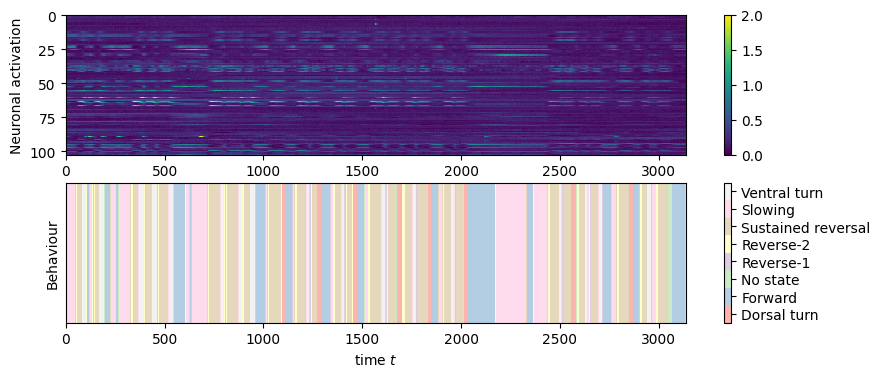

In [2]:
worm_num = 0
b_neurons = [
	'AVAR',
	'AVAL',
	'SMDVR',
	'SMDVL',
	'SMDDR',
	'SMDDL',
	'RIBR',
	'RIBL'
]
data = Database(data_set_no=worm_num)
data.exclude_neurons(b_neurons)
X = data.neuron_traces.T
B = data.states
state_names = ['Dorsal turn', 'Forward', 'No state', 'Reverse-1', 'Reverse-2', 'Sustained reversal', 'Slowing', 'Ventral turn']
plotting_neuronal_behavioural(X, B, state_names=state_names)

## Preprocess data and embed with BunDLe-Net

In [3]:
### Preprocess and prepare data for BundLe Net
time, X = preprocess_data(X, data.fps)
X_, B_ = prep_data(X, B, win=15)

### Deploy BunDLe Net
model = BunDLeNet(latent_dim=3)
model.build(input_shape=X_.shape)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

loss_array = train_model(
	X_,
	B_,
	model,
	optimizer,
	gamma=0.9, 
	n_epochs=2000,
	pca_init=False,
	best_of_5_init=False
)

Losses 0.006386 0.003448 0.009834: 100%|███████| 2000/2000 [01:46<00:00, 18.70it/s]


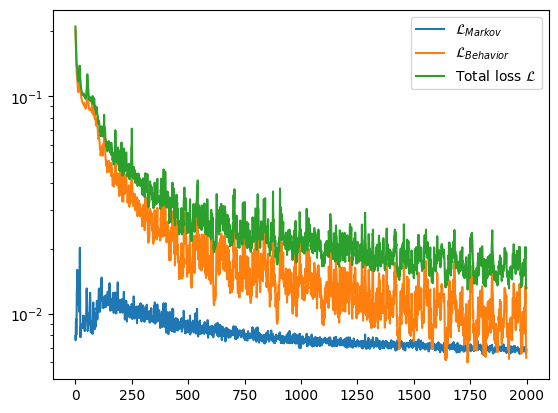

In [4]:
# Training losses vs epochs
plt.figure()
for i, label in  enumerate(["$\mathcal{L}_{{Markov}}$", "$\mathcal{L}_{{Behavior}}$","Total loss $\mathcal{L}$" ]):
	plt.semilogy(loss_array[:,i], label=label)
plt.legend()
plt.show()

## Projecting into latent space

In [5]:
Y0_ = model.tau(X_[:,0]).numpy() 

## Visualising embedding

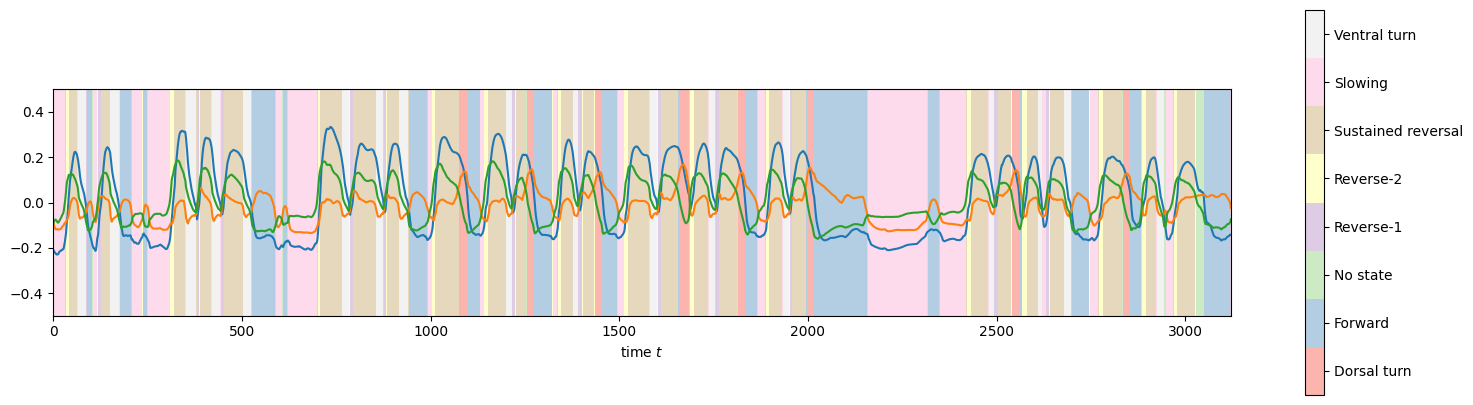

In [6]:
plot_latent_timeseries(Y0_, B_, state_names)

In [15]:
%matplotlib notebook
plot_phase_space(Y0_, B_, state_names = state_names)

In [8]:
### Run to produce rotating 3-D plot
#%matplotlib notebook
# rotating_plot(Y0_, B_,filename='figures/rotation_'+ algorithm + '_worm_'+str(worm_num) +'.gif', state_names=state_names, legend=False)

### Performing PCA on the latent dimension (to check if there are redundant or correlated components)


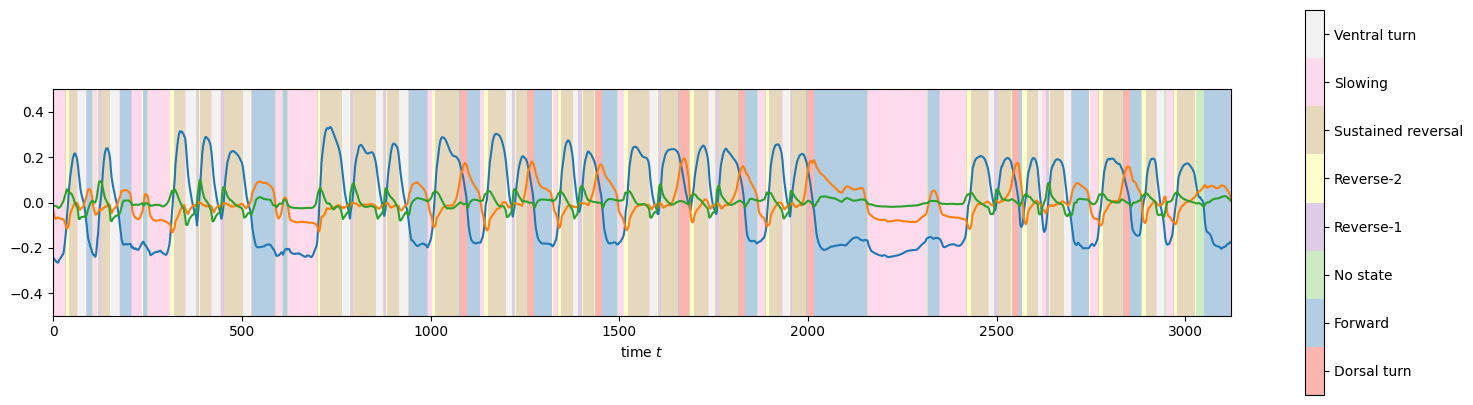

In [10]:
%matplotlib inline
pca = PCA()
Y_pca = pca.fit_transform(Y0_)
plot_latent_timeseries(Y_pca, B_, state_names)


### Recurrence plot analysis of BunDLeNet's embedding

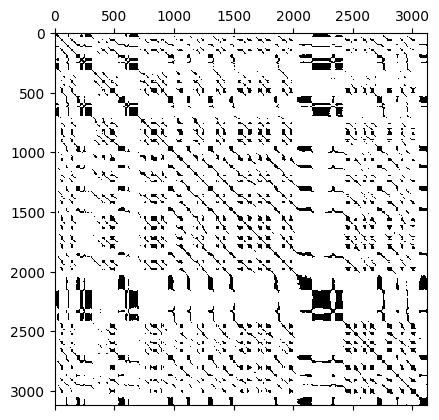

In [12]:
pd_Y = np.linalg.norm(Y0_[:, np.newaxis] - Y0_, axis=-1) < 0.8
plt.matshow(pd_Y, cmap='Greys')
plt.show()